In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from pytorch_lightning import LightningModule, Trainer
import kornia as K
from sklearn.model_selection import train_test_split

import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import os
import glob

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
list_train = glob.glob('TrainIJCNN2013/TrainIJCNN2013' + '/*')
list_train = [string.split('/')[-1] for string in list_train if '.ppm' in string]
len(list_train), list_train[0]

(600, '00316.ppm')

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    # x_min, y_min, w, h = bbox
    bbox = [int(i) for i in bbox]
    x_min, y_min, x_max, y_max = bbox
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(str(class_name), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=str(class_name),
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name=None):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        if category_id_to_name:
            class_name = category_id_to_name[category_id]
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('TrainIJCNN2013/TrainIJCNN2013/gt.txt', sep=';', header=None)
data.rename(columns={0: "image", 5: "class"}, inplace=True)
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


<AxesSubplot:ylabel='Frequency'>

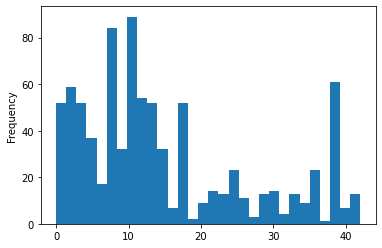

In [7]:
data['class'].plot.hist(bins=30)

In [8]:
data[data['image'] == '00001.ppm']

,image,1,2,3,4,class
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13


In [9]:
# data.drop(data[(data['class'] == 41) | (data['class'] == 42)].index, inplace=True)
# data.reset_index(drop=True, inplace=True)
# data

In [10]:
# data[data['class'] == 32].head() # 12, 14, 17, 41 ,42

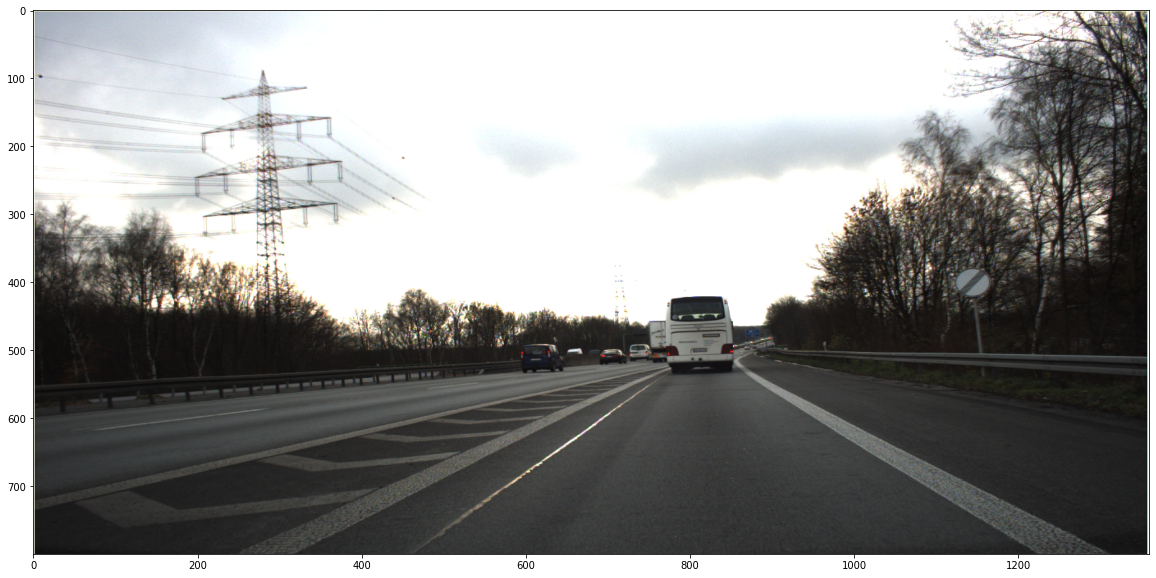

In [11]:
im = cv2.imread('TrainIJCNN2013/TrainIJCNN2013/00317.ppm')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (20,10))
plt.imshow(im, aspect='auto')

In [12]:
def get_label(label):
    prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]  # (circular, white ground with red border)
    mandatory = [33, 34, 35, 36, 37, 38, 39, 40]  # (circular, blue ground)
    danger = [11, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]  # (triangular, white ground with red border)
    # rare = [12, 14, 17, 41 ,42] 

    if label in prohibitory:
        new_label = 0
    elif label in mandatory:
        new_label = 1
    elif label in danger:
        new_label = 2
    else:
        new_label = 3

    return new_label

In [13]:
data['class'] = data['class'].apply(get_label)

In [14]:
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,2
1,00001.ppm,983,388,1024,432,1
2,00001.ppm,386,494,442,552,1
3,00001.ppm,973,335,1031,390,2
4,00002.ppm,892,476,1006,592,1


In [15]:
ser = data[data['image'] == '00001.ppm']

In [16]:
for index, row in ser.iterrows():
    print(index)
    print(row['image'])


1
00001.ppm
2
00001.ppm
3
00001.ppm


<AxesSubplot:ylabel='Frequency'>

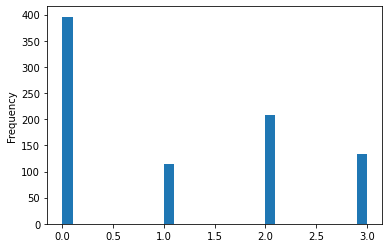

In [17]:
data['class'].plot.hist(bins=30)

In [18]:
stratify = data['class'].value_counts().values
stratify = stratify/stratify.sum()
stratify

array([0.46478873, 0.24413146, 0.157277  , 0.13380282])

In [19]:
train, val = train_test_split(data, test_size=0.2, stratify=data['class'])

In [20]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [21]:
train

,image,1,2,3,4,class
0,00431.ppm,1141,496,1179,536,0
1,00466.ppm,514,468,548,497,2
2,00297.ppm,1015,444,1042,468,2
3,00439.ppm,1194,504,1251,564,0
4,00055.ppm,702,413,747,455,2
...,...,...,...,...,...,...
676,00373.ppm,819,511,853,545,0
677,00457.ppm,517,466,554,504,0
678,00349.ppm,53,455,114,514,0
679,00088.ppm,956,440,981,464,0


In [22]:
'''
class Augmentation_train(nn.Module):
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.Resize((480, 640)),
    # K.augmentation.RandomHorizontalFlip(p=0.5),
    # K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(20, p=0.8),
    # K.augmentation.RandomElasticTransform(p=0.4),
    K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25, p=0.5),
    data_keys=['input', 'bbox'],
    same_on_batch=False,
    keepdim=True,
    )

    def __init__(self):
        super(Augmentation_train, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, bbox)

    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:
        # img = transform(img)
        x = self._augmentations(img, bbox)
        return x

class Augmentation_val(nn.Module):
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.Resize((480, 640)),
    data_keys=['input', 'bbox'],
    keepdim=True,
    )

    def __init__(self):
        super(Augmentation_val, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, bbox)

    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:
        # img = transform(img)
        x = self._augmentations(img, bbox)
        return x

Aug_tr, Aug_val = Augmentation_train(), Augmentation_val()
'''

"\nclass Augmentation_train(nn.Module):\n    _augmentations = K.augmentation.AugmentationSequential(\n    K.augmentation.Resize((480, 640)),\n    # K.augmentation.RandomHorizontalFlip(p=0.5),\n    # K.augmentation.RandomVerticalFlip(p=0.5),\n    K.augmentation.RandomRotation(20, p=0.8),\n    # K.augmentation.RandomElasticTransform(p=0.4),\n    K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25, p=0.5),\n    data_keys=['input', 'bbox'],\n    same_on_batch=False,\n    keepdim=True,\n    )\n\n    def __init__(self):\n        super(Augmentation_train, self).__init__()\n\n    @torch.no_grad()\n    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:\n        return self.augmentations(img, bbox)\n\n    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:\n        # img = transform(img)\n        x = self._augmentations(img, bbox)\n        return x\n\nclass Augmentation_val(nn.Module):\n    _augmentations = K.augmentation.AugmentationSequential(\n    K.au

In [23]:
transform = A.Compose([
    A.Resize(width=640, height=480),
    # A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [24]:
class DetectionDataset(Dataset):
    def __init__(self, data, root, transforms = None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.names = data['image'].unique()

    def __getitem__(self, idx):
        name = self.names[idx]
        df = self.data[self.data['image'] == name]
        img_path = os.path.join(self.root, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        bboxes = []
        labels = []
        # print(df)
        for index, row in df.iterrows():
            # print(row)
            bboxes.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])
            labels.append(row['class'])

        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=bboxes, category_ids=labels)
            img = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['category_ids']
        target = {}
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        # target["boxes"] = bboxes
        # target["labels"] = labels
        img = torch.as_tensor(img).float().permute(2,0,1)
        return img, target
        # return img, bboxes, labels

    def __len__(self):
        return len(self.names)

def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
train_set = DetectionDataset(train, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)
val_set = DetectionDataset(val, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)


In [26]:
im, targets = train_set[2]

In [27]:
im.max()

tensor(255.)

In [28]:
im.shape, targets

(torch.Size([3, 480, 640]),
 {'boxes': tensor([[477.6471, 266.4000, 490.3529, 280.8000],
          [279.0588, 265.8000, 291.7647, 279.6000]]),
  'labels': tensor([2, 2])})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


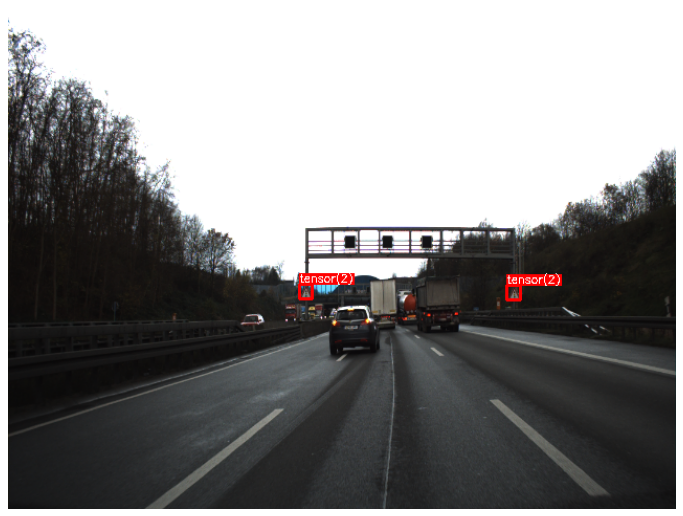

In [29]:
visualize(im.permute(1,2,0).numpy() / 255., targets['boxes'], targets['labels'])

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [31]:
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 4  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [32]:
data_loader = torch.utils.data.DataLoader(
 train_set, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn,
 )
val_loader = torch.utils.data.DataLoader(
 val_set, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn,
 )


In [33]:
images,targets = next(iter(data_loader))

In [34]:
len(images)

2

In [35]:
# # imges = list(torch.as_tensor(image).permute(2, 0 , 1).long() / 255. for image in images)
# imges = list(image.long() / 255. for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# model.train()
# output = model(imges, targets)   # Returns losses and detections
# # For inference
# model.eval()
# # x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(imges)
# print('targets: ', targets)
# print('output: ', output)
# print('predictions: ', predictions)

In [36]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [37]:
# metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
# metric.update(predictions, targets)
# metric.compute()

In [39]:
class FasterRCNN(LightningModule):
    def __init__(self,n_classes):
        super().__init__()
        self.detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        self.detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        self.lr = 1e-4
        self.metric = MeanAveragePrecision()

    def forward(self, imgs,targets=None):
      # Torchvision FasterRCNN returns the loss during training 
      # and the boxes during eval
      self.detector.eval()
      return self.detector(imgs)

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
      return optimizer

    def training_step(self, batch, batch_idx):
      images,targets = batch
      targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

      # fasterrcnn takes both images and targets for training, returns
      loss_dict = self.detector(images, targets)
      loss = sum(loss for loss in loss_dict.values())
      return {"loss": loss, "log": loss_dict}

    def validation_step(self, batch, batch_idx):
      img, boxes = batch
      pred_boxes =self.forward(img)
      self.val_loss = self.metric(pred_boxes, boxes)
      return {"val_loss": self.val_loss['map']}

    def validation_epoch_end(self, outputs):
      loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
      log_dict = {"val_loss": loss_val.detach()}
      # Логи валидационных эпох для tensorboard
      self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)

      return log_dict

In [35]:
# det_model = Detection_model()
det_model = FasterRCNN(4)

In [36]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [37]:
checkpoint_callback = ModelCheckpoint(dirpath=f"lightning_logs", save_top_k=2, monitor="val_epoch_total_step")

In [46]:
trainer = Trainer(gpus=1,
 max_epochs=100,
 callbacks=[checkpoint_callback]
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [47]:
trainer.fit(det_model,
data_loader,val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | detector | FasterRCNN           | 41.3 M
1 | metric   | MeanAveragePrecision | 0     
--------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.238   Total estimated model params size (MB)
/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/tims/work/myprojects/traffic/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:633: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [40]:
images,targets = next(iter(val_loader))

In [41]:
model = FasterRCNN(4)

In [42]:
model = model.load_from_checkpoint(checkpoint_path='lightning_logs/epoch=1-step=453.ckpt', n_classes=4)

In [43]:
model = model.to('cpu')

In [44]:
out = model(images)

In [45]:
out[1]

{'boxes': tensor([[110.6690, 309.9966, 121.5863, 318.5786],
         [ 53.1837, 326.7798,  76.4744, 340.9630],
         [122.5957, 321.8354, 141.7433, 342.8710],
         [ 55.2072, 322.0671,  71.4218, 347.0046],
         [125.4104, 325.7621, 140.4606, 352.1100],
         [ 40.2709, 333.0882,  72.3144, 343.7367],
         [ 46.6342, 329.7080,  73.6311, 350.6387],
         [ 98.3619, 301.7811, 124.7042, 320.7115],
         [105.8107, 299.8759, 121.4957, 326.1230],
         [ 48.7770, 327.9391,  63.0106, 352.7076],
         [ 30.6574, 338.6409,  74.7810, 348.4572],
         [400.4368, 275.1057, 418.9366, 290.5554]], grad_fn=<StackBackward0>),
 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'scores': tensor([0.1687, 0.1588, 0.1382, 0.1155, 0.1086, 0.1052, 0.0912, 0.0852, 0.0795,
         0.0639, 0.0577, 0.0517], grad_fn=<IndexBackward0>)}

In [46]:
images[0]

tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 173., 177.,  ..., 255., 215., 255.],
         [255., 175., 175.,  ..., 247.,  92., 255.],
         ...,
         [255.,  19.,  19.,  ...,  62.,  47., 255.],
         [255.,  20.,  21.,  ...,  42.,  27., 255.],
         [255.,  21.,  21.,  ...,  63.,  33., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 177., 178.,  ..., 255., 204., 255.],
         [255., 181., 181.,  ..., 248., 116., 255.],
         ...,
         [255.,  19.,  20.,  ...,  67.,  67., 255.],
         [255.,  20.,  21.,  ...,  46.,  50., 255.],
         [255.,  20.,  20.,  ...,  62.,  58., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 138., 144.,  ..., 255., 203., 255.],
         [255., 175., 187.,  ..., 255., 116., 255.],
         ...,
         [255.,  13.,  21.,  ...,  64.,  65., 255.],
         [255.,  13.,  22.,  ...,  43.,  44., 255.],
         [255.,  15.,  22.,  ...,  61.,  52., 255.]]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


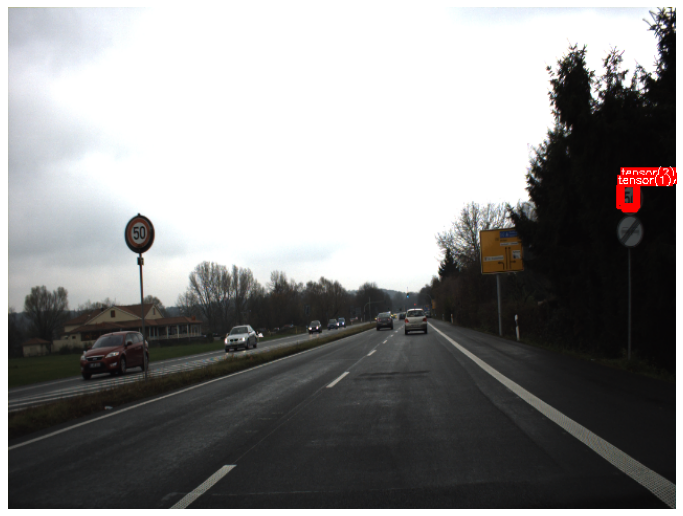

In [49]:
visualize(images[0].permute(1,2,0).numpy() / 255., out[0]['boxes'][0:3], out[0]['labels'][0:3])

In [ ]:
# class Detection_model(LightningModule):
#     def __init__(self):
#         super(Detection_model, self).__init__()
#         self.model = model.train()
#     def forward(self, x, *args, **kwargs):
#         return self.model(x)
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
#         scheduler = {
#             'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
#             'monitor' : 'losses',
#         }
#         return {
#                 "optimizer": optimizer,
#                 "lr_scheduler": scheduler,
#                 }
#     def training_step(self, batch, batch_idx):
#         images, targets = batch
#         targets = [{k: v for k, v in t.items()} for t in targets]
#         loss_dict = self.model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}
#     def validation_step(self, batch, batch_idx):
#         images, targets = batch
#         targets = [{k: v for k, v in t.items()} for t in targets]
#         outputs = self.model(images, targets)
#         losses = sum(loss for loss in outputs.values())
#         return {'val_loss' : losses}
#     def validation_epoch_end(self, outputs):
#         loss_val = torch.stack([x["val_loss"] for x in outputs]).mean().detach()
#         return {'val_loss_end': loss_val}